# DFUC24 Baseline: SAM fine-tuning for semantic ulcer segmentation on DFUC22 dataset

The author of this notebook is Benjamin Bracke ([Github](https://github.com/B-Bracke)).

## Imports

In [2]:
import os
import glob
import copy
import json
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
import albumentations as A
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import autocast
from torch.cuda.amp import GradScaler

from torchmetrics import MetricCollection
from torchmetrics.aggregation import MeanMetric
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score, BinaryRecall, BinaryPrecision, BinaryConfusionMatrix
from torchmetrics.detection.iou import IntersectionOverUnion
from torchmetrics.detection.mean_ap import MeanAveragePrecision

#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "1"

## Defining important path variables

In [ ]:
ROOT_DIR = os.path.abspath(os.getcwd()) # current path of the notebook
DATA_DIR = "/raid/DFUC24/datasets/dfuc2022/sep/" # path to the dataset root directory
IMAGE_FILES = os.path.join(DATA_DIR, "images/") # path to the images
ANNOTATION_FILES = os.path.join(DATA_DIR, "labels/") # path to the ground truth annotations

print("Directories:")
print("Root directory:", ROOT_DIR)
print("Image files in directory:", IMAGE_FILES)
print("Ground Truth annotations files in directory:", ANNOTATION_FILES)

## Data set

### Define the dataset class, pre-processing and augmentation pipelines and helper functions

In [ ]:
import cv2
import json
import numpy as np
import torch
from torch.utils.data import Dataset
import albumentations as A

class DFUC22_Dataset(Dataset):
    def __init__(self, image_files: list, mask_files: list, annotations_file: str, pre_transform=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.annotations_file = annotations_file
        self.transform = pre_transform  # albumentation augmentation pipeline

        # Load COCO annotations
        with open(annotations_file, 'r') as f:
            self.coco_annotations = json.load(f)

        self.image_id_to_annotations = self._map_image_id_to_annotations()

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        img_file = self.image_files[index]
        mask_file = self.mask_files[index]
        
        # Load image and mask using OpenCV
        img = cv2.cvtColor(cv2.imread(img_file, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE) 

        # Get bbox annotations for the image
        img_id = self._get_image_id(img_file)
        annotations = self.image_id_to_annotations.get(img_id, [])
        bboxes = [ann['bbox'] for ann in annotations]
        labels = [ann['category_id'] for ann in annotations]
        area = [ann['area'] for ann in annotations]

        # Apply transformations
        if self.transform:
            transformed = self.transform(image=img, mask=mask, bboxes=bboxes, labels=labels)
            img = transformed['image']
            mask = transformed['mask']
            bboxes = transformed['bboxes']
            labels = transformed['labels']

        img = np.rollaxis(img, -1, 0)
        img = torch.from_numpy(img).to(torch.uint8)
        mask = torch.from_numpy(mask).to(torch.float32)

        # Convert bbox format from [x, y, width, height] to (center_x, center_y, w, h) and normalize bbox format by image size
        bboxes = [[x + w / 2, y + h / 2, w, h] for x, y, w, h in bboxes]
        bboxes = [[x / img.shape[2], y / img.shape[1], w / img.shape[2], h / img.shape[1]] for x, y, w, h in bboxes]
        
        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        area = torch.tensor(area, dtype=torch.float32)

        return img, mask, {'boxes': bboxes, 'class_labels': labels, 'area':area}

    def _map_image_id_to_annotations(self):
        image_id_to_annotations = {}
        for ann in self.coco_annotations['annotations']:
            image_id = ann['image_id']
            image_id = [int(img["file_name"].split(".")[0]) for img in self.coco_annotations['images'] if img["id"]==image_id][0]
            
            if image_id not in image_id_to_annotations:
                image_id_to_annotations[image_id] = []
            image_id_to_annotations[image_id].append(ann)
        return image_id_to_annotations

    def _get_image_id(self, img_file):
        # Extract the image id from the image file name
        # This assumes the image file names are structured to allow this extraction.
        # Adjust this method as per your file naming convention.
        img_id = int(img_file.split('/')[-1].split('.')[0])
        return img_id

def collate_fn(batch):
    images, masks, targets = [], [], []
    
    for b in batch:
        images.append(b[0])
        masks.append(b[1])
        targets.append(b[2])

    images = torch.stack(images)
    masks = torch.stack(masks)
    return images, masks, targets

import copy

def move_to_device(batch, device):
    """
    Move a batch of tensors (list of dictionaries) to the specified device.
    
    Args:
    - batch (list of dict): A list of dictionaries containing tensors.
    - device (torch.device): The target device to move the tensors to.
    
    Returns:
    - list of dict: A list of dictionaries with tensors moved to the specified device.
    """
    return [{key: value.to(device) if torch.is_tensor(value) else value for key, value in sample.items()} for sample in batch]


def cxcywh2xyxy(boxes):
    """
    Convert bounding boxes from cx, cy, w, h format to x1, y1, x2, y2 format

    Args:
    boxes (list of dict): List of dictionaries, each containing a key "boxes" 
                          with a tensor value in the format [[cx, cy, w, h]].
    """
    converted_boxes = copy.deepcopy(boxes)
    for box_dict in converted_boxes:
        boxes_tensor = box_dict['boxes']
        x1 = boxes_tensor[:, 0] - boxes_tensor[:, 2] / 2  # x1
        y1 = boxes_tensor[:, 1] - boxes_tensor[:, 3] / 2  # y1
        x2 = boxes_tensor[:, 0] + boxes_tensor[:, 2] / 2  # x2
        y2 = boxes_tensor[:, 1] + boxes_tensor[:, 3] / 2  # y2
        box_dict['boxes'] = torch.stack([x1, y1, x2, y2], dim=1)
    return converted_boxes

def convert_bbox_format2sam_prompts(data, image_width, image_height):
    result = []
    max_boxes = 0
    
    # First pass to find the maximum number of boxes
    for item in data:
        boxes_tensor = item['boxes']
        num_boxes = boxes_tensor.shape[0] if boxes_tensor.numel() > 0 else 0
        max_boxes = max(max_boxes, num_boxes)
    
    # Second pass to convert and pad boxes
    for item in data:
        boxes_tensor = item['boxes']
        if boxes_tensor.numel() == 0:
            boxes_list = []
        else:
            # Convert from image size normalized xyxy to non-normalized xyxy format
            boxes = boxes_tensor.cpu().tolist()
            converted_boxes = []
            for box in boxes:
                x1 = box[0] * image_width
                y1 = box[1] * image_height
                x2 = box[2] * image_width
                y2 = box[3] * image_height
                converted_boxes.append([x1, y1, x2, y2])
            
            boxes_list = converted_boxes
        
        # Pad the boxes_list if it has fewer than max_boxes elements
        while len(boxes_list) < max_boxes:
            boxes_list.append([0, 0, 0, 0])

        result.append(boxes_list)
    
    return result

# albumentation pre-processing and augmentation pipeline for the training images 
pre_transform = A.Compose([
        A.Flip(p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    ], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))

id2label = {
    0: "background.",
    1: "wound."}
print(f"label classes {id2label}")

### Initializing the test data set and data loader

In [ ]:
# load image and mask filenames from disk
train_image_files = sorted(glob.glob(IMAGE_FILES + '/train/*.png'))
train_mask_files = sorted(glob.glob(ANNOTATION_FILES + '/train/*.png'))
train_annotation_file = ANNOTATION_FILES + '/instances_train.json'

valid_image_files = sorted(glob.glob(IMAGE_FILES + '/valid/*.png'))
valid_mask_files = sorted(glob.glob(ANNOTATION_FILES + '/valid/*.png'))
valid_annotation_file = ANNOTATION_FILES + '/instances_val.json'

# create train and validation datasets
train_dataset = DFUC22_Dataset(train_image_files, train_mask_files, train_annotation_file, pre_transform)
valid_dataset = DFUC22_Dataset(valid_image_files, valid_mask_files, valid_annotation_file, None)
print(f'Found {len(train_dataset)} training images')
print(f'Found {len(valid_dataset)} validation images')

# create train and validation data loaders
BATCH_SIZE = 8 # batch size for single forward pass 
ACC_STEPS = 4 # steps for gradient accumulation

# train data loader
train_loader = DataLoader(dataset=train_dataset,
                          collate_fn=collate_fn,
                          shuffle=True, 
                          batch_size=BATCH_SIZE, 
                          num_workers=4, 
                          pin_memory=True,
                          drop_last=True,
                          persistent_workers=True)

# validation data loader
valid_loader = DataLoader(dataset=valid_dataset,
                          collate_fn=collate_fn,
                          shuffle=False, 
                          batch_size=BATCH_SIZE, 
                          num_workers=4, 
                          pin_memory=True,
                          persistent_workers=True)

print("Datasets prepared")

### Display some images

In [6]:
dataiter = iter(train_loader) # get iterator of train_loader 

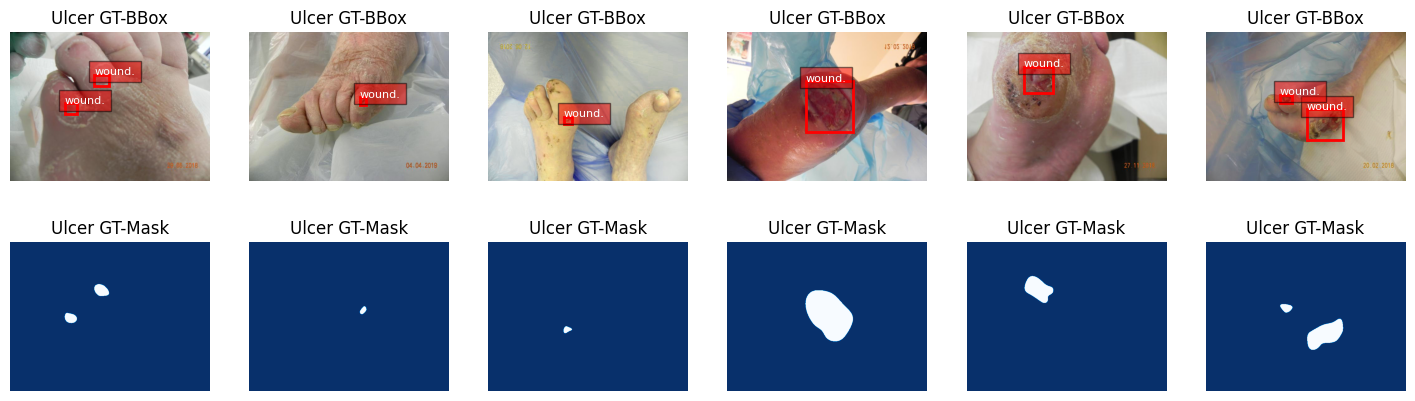

In [11]:
def show_subset(images, masks, targets, n):
    fig, ax = plt.subplots(2, n, figsize=(n*3, 5))
    for i in range(n):
        img = images[i].numpy()
        img = np.rollaxis(img, 0, 3) # np.rollaxis to swap channel axes to channels last
        mask = masks[i].numpy()
        bboxes = targets[i]['boxes'].numpy()
        labels = targets[i]['class_labels'].numpy()

        ax[0, i].imshow(img, vmin=0, vmax=1, cmap='gray') 
        ax[1, i].imshow(mask, vmin=0, vmax=1, cmap='Blues_r')   
        
        for bbox, label in zip(bboxes, labels):          
            x_min, y_min, w, h = bbox[0] - bbox[2] / 2, bbox[1] - bbox[3] / 2, bbox[2], bbox[3] # convert cx, cy, w, h, to x, y, w, h
            x_min, y_min, w, h = x_min * img.shape[1], y_min * img.shape[0], w * img.shape[1], h * img.shape[0] # denormalize bbox format
            rect = plt.Rectangle((x_min, y_min), w, h, linewidth=2, edgecolor='red', facecolor='none')
            ax[0, i].add_patch(rect)
            ax[0, i].text(x_min, y_min, id2label[label], color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))
        
        ax[0, i].set_title('Ulcer GT-BBox')
        ax[1, i].set_title('Ulcer GT-Mask')
        ax[1, i].axis('off')
        ax[0, i].axis('off')

    plt.show()

images, masks, targets = next(dataiter) # get a random batch of train_loader iterator
show_subset(images, masks, targets, n=6) # show images, masks subset of size n of batch

## Defining the model

In [12]:
device = ("cuda" if torch.cuda.is_available() else "cpu") 
print(f"device: {device}")

device: cuda


### SAM Model

In [ ]:
from transformers import SamProcessor, SamModel

MODEL_DIR = "./models/sam_finetune/" # path to save the model checkpoints, logs, etc.
print("model_dir: ", os.path.realpath(MODEL_DIR))
os.makedirs(MODEL_DIR, exist_ok=True)

sam_model_id = "facebook/sam-vit-huge"
sam_model = SamModel.from_pretrained(sam_model_id, return_dict=True).to(device)
sam_model.train()
sam_processor = SamProcessor.from_pretrained(sam_model_id)


# load checkpoint if available
CHECKPOINTS = None # "./models/sam_finetune/model_epoch29.pth"
if CHECKPOINTS:
    sam_model.load_state_dict(torch.load(f'{CHECKPOINTS}', map_location='cpu'))
    torch.cuda.empty_cache()
    print(f"use model checkpoints: {CHECKPOINTS}")

   
for name, param in sam_model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad = False
      
print(sam_model)

## Train the model

### Define the optimizer, gradient scaler and loss function and metrics

In [14]:
import monai

scaler = GradScaler()

# optimizer 
LEARN_RATE = 1e-05
optimizer = torch.optim.AdamW(filter(lambda param: param.requires_grad, sam_model.parameters()), lr=LEARN_RATE, weight_decay=0.01)

loss_function = monai.losses.DiceLoss(sigmoid=True, reduction='mean')

loss_metric = MeanMetric().to(device)
metrics = MetricCollection({
    "dice": BinaryF1Score(threshold=0.5),
    'iou': BinaryJaccardIndex(threshold=0.5),
}).to(device)

logs = {'loss': [], 'iou': [], 'dice': [], 'val_loss': [], 'val_iou': [], 'val_dice': []}

### Training loop

In [ ]:
NUM_EPOCHS = 30 # number of epochs to train

start_training = time.perf_counter() # start time of trainig

for epoch in range(NUM_EPOCHS):
    epoch_start = time.perf_counter()  # start time of epoch
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
    
    ############################## train phase ####################################
    sam_model.train()

    # zero the parameter gradients
    optimizer.zero_grad(set_to_none=True)
    torch.cuda.empty_cache()
    
    # iterate over training batches
    for batch_idx, (images, masks, targets) in enumerate(train_loader):        
        sam_prompts = convert_bbox_format2sam_prompts(cxcywh2xyxy(targets), image_width=images.shape[3], image_height=images.shape[2])
        sam_inputs = sam_processor(images=images, input_boxes=sam_prompts, return_tensors="pt").to(device)
        
        # forward SAM to get segmentation predictions
        with autocast(device_type='cuda', dtype=torch.float16):
            sam_outputs = sam_model(**sam_inputs, return_dict=True, multimask_output=False)
        
        pred_masks = sam_processor.post_process_masks(masks=sam_outputs.pred_masks,original_sizes=sam_inputs.original_sizes,reshaped_input_sizes=sam_inputs.reshaped_input_sizes,binarize=False) # Do not binarise here as gradients will be lost
        pred_masks = torch.stack([torch.max(mask, dim=0).values.squeeze() for mask in pred_masks], dim=0)  # combine multiply seg. instances into one semantic seg.
        loss = loss_function(pred_masks, masks.to(device)) / ACC_STEPS

        # backpropagating the loss
        scaler.scale(loss).backward()
    
        # gradient accumulation
        if (batch_idx + 1) % ACC_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(sam_model.parameters(), 0.1)  # optimize with gradient clipping to 1 with mixed precision
            scaler.step(optimizer)
            scaler.update()
            # zero the parameter gradients
            optimizer.zero_grad(set_to_none=True)        
        
        # Compute metrics for batch
        loss_metric.update((loss * ACC_STEPS).detach())
        pred_masks = (pred_masks.sigmoid() > 0.5).int() # binarize here after loss computation
        metrics.update(pred_masks, masks.to(device))

    # compute metrics for epoch and reset metrics
    epoch_loss = loss_metric.compute()
    epoch_metrics = metrics.compute()
    loss_metric.reset()
    metrics.reset()
    
    # Append metric results to logs
    logs['loss'].append(epoch_loss.cpu().item())
    logs['dice'].append(epoch_metrics['dice'].cpu().item())
    logs['iou'].append(epoch_metrics['iou'].cpu().item())
    print(f"loss: {logs['loss'][epoch]:.5f}, dice: {logs['dice'][epoch]:.5f}, iou: {logs['iou'][epoch]:.5f}", end=' || ')

    # zero the parameter gradients
    optimizer.zero_grad(set_to_none=True)
    torch.cuda.empty_cache()

    ############################## valid phase ####################################
    with torch.no_grad():
        sam_model.eval()
    
        # iterate over validation batches
        for (images, masks, targets) in valid_loader:
            sam_prompts = convert_bbox_format2sam_prompts(cxcywh2xyxy(targets), image_width=images.shape[3], image_height=images.shape[2])
            sam_inputs = sam_processor(images=images, input_boxes=sam_prompts, return_tensors="pt").to(device)
            
            # forward SAM to get segmentation predictions
            with autocast(device_type='cuda', dtype=torch.float16):
                sam_outputs = sam_model(**sam_inputs, return_dict=True, multimask_output=False)

            pred_masks = sam_processor.post_process_masks(masks=sam_outputs.pred_masks,original_sizes=sam_inputs.original_sizes,reshaped_input_sizes=sam_inputs.reshaped_input_sizes,binarize=False) # Do not binarise here as gradients will be lost
            pred_masks = torch.stack([torch.max(mask, dim=0).values.squeeze() for mask in pred_masks], dim=0)  # combine multiply seg. instances into one semantic seg.
            loss = loss_function(pred_masks, masks.to(device))
    
            # Compute metrics for batch
            loss_metric.update((loss).detach())
            pred_mask = (pred_masks.sigmoid() > 0.5).int() # binarize here after loss computation
            metrics.update(pred_mask, masks.to(device))
    
        # compute metrics for epoch and reset metrics
        epoch_loss = loss_metric.compute()
        epoch_metrics = metrics.compute()
        loss_metric.reset()
        metrics.reset()
    
        # Append metric results to logs
        logs['val_loss'].append(epoch_loss.cpu().item())
        logs['val_dice'].append(epoch_metrics['dice'].cpu().item())
        logs['val_iou'].append(epoch_metrics['iou'].cpu().item())
        print(f"val_loss: {logs['val_loss'][epoch]:.5f}, val_dice: {logs['val_dice'][epoch]:.5f}, val_iou: {logs['val_iou'][epoch]:.5f}", end=' || ')
        
    # save logs as csv
    logs_df = pd.DataFrame(logs)
    logs_df.to_csv(f'{MODEL_DIR}train_history.csv', index_label='epoch', sep=',', encoding='utf-8')

    #save trained model for each epoch
    torch.save(sam_model.state_dict(), f'{MODEL_DIR}model_epoch{epoch}.pth')
    torch.save(optimizer.state_dict(), f'{MODEL_DIR}optimizer_epoch{epoch}.pth')
    torch.save(scaler.state_dict(), f'{MODEL_DIR}mp_scaler_epoch{epoch}.pth')

    epoch_end = time.perf_counter()  # end time of epoch
    print(f"epoch runtime: {epoch_end-epoch_start:5.3f} sec.")
    torch.cuda.empty_cache()

#save trained model for each epoch
torch.save(sam_model.state_dict(), f'{MODEL_DIR}model_epoch{epoch}.pth')
torch.save(optimizer.state_dict(), f'{MODEL_DIR}optimizer_epoch{epoch}.pth')
torch.save(scaler.state_dict(), f'{MODEL_DIR}mp_scaler_epoch{epoch}.pth')

# end time of trainig
end_training = time.perf_counter()
print(f'Training succeeded in {(end_training - start_training):5.3f}s')

### Visualization of the training process

In [ ]:
metrics_keys = ['loss', 'iou', 'dice']
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

for i, metric in enumerate(metrics_keys):
    ax[i].plot(logs[metric], label='train')
    ax[i].plot(logs[f'val_{metric}'], label='valid')
    ax[i].set_title(f'Model {metric}')
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(0, NUM_EPOCHS-1)
    ax[i].set_ylabel(metric)
    ax[i].set_xlabel('Epoch')
    ax[i].legend(loc='best')
    
fig.tight_layout()
fig.savefig(f'{MODEL_DIR}/training_history.png', dpi=100, format="png")
plt.show()

## Final Validation of the trained model

In [ ]:
sam_metrics = MetricCollection({
    "dice": BinaryF1Score(threshold=0.5),
    'iou': BinaryJaccardIndex(threshold=0.5),
    'recall': BinaryRecall(threshold=0.5),
    'precision': BinaryPrecision(threshold=0.5),
    'cm': BinaryConfusionMatrix(normalize=None, threshold=0.5)
})


with torch.no_grad():
    sam_model.eval()

    for (images, masks, targets) in tqdm(valid_loader):
        sam_prompts = convert_bbox_format2sam_prompts(cxcywh2xyxy(targets), image_width=images.shape[3], image_height=images.shape[2])
        sam_inputs = sam_processor(images=images, input_boxes=sam_prompts, return_tensors="pt").to(device)

        # forward SAM to get segmentation predictions
        with autocast(device_type='cuda', dtype=torch.float16):
            sam_outputs = sam_model(**sam_inputs, return_dict=True, multimask_output=False)

        pred_masks = sam_processor.post_process_masks(masks=sam_outputs.pred_masks,original_sizes=sam_inputs.original_sizes,reshaped_input_sizes=sam_inputs.reshaped_input_sizes,binarize=False) # Do not binarise here as gradients will be lost
        pred_masks = torch.stack([torch.max(mask, dim=0).values.squeeze() for mask in pred_masks], dim=0) # combine multiply seg. instances into one semantic seg.

        # compute SAM segmentation metrics
        pred_mask = (pred_masks.sigmoid() > 0.5).int() # binarize here
        sam_metrics.update(pred_mask.cpu(), masks)


# calculate test metric results
eval_sam_metrics = sam_metrics.compute()
eval_sam_metrics["fpv"] = eval_sam_metrics['cm'][0,1] / (eval_sam_metrics['cm'][0,1] + eval_sam_metrics['cm'][0,0])
eval_sam_metrics["fnv"] = eval_sam_metrics['cm'][1,0] / (eval_sam_metrics['cm'][1,0] + eval_sam_metrics['cm'][1,1])
eval_sam_metrics["ncm"] = eval_sam_metrics["cm"] / torch.sum(eval_sam_metrics["cm"], dim=1, keepdim=True)

print(f"Testdata evaluation results:\n", 
      f"SAM_IoU: {eval_sam_metrics['iou'].item():.5f}\n",
      f"SAM_Dice: {eval_sam_metrics['dice'].item():.5f}\n",
      f"SAM_Recall: {eval_sam_metrics['recall'].item():.5f}\n",
      f"SAM_Precision: {eval_sam_metrics['precision'].item():.5f}\n",
      f"SAM_FPE: {eval_sam_metrics['fpv'].item():.5f}\n",
      f"SAM_FNE: {eval_sam_metrics['fnv'].item():.5f}\n"
)

# Save the metrics as a JSON file

# Function to convert tensors to standard Python data types
def convert_tensors(metrics_dict):
    converted_metrics = {}
    for key, value in metrics_dict.items():
        if isinstance(value, (np.ndarray, list, torch.Tensor)):
            converted_metrics[key] = value.tolist()
        elif hasattr(value, 'item'):  # for single-value tensors
            converted_metrics[key] = value.item()
        else:
            converted_metrics[key] = value
    return converted_metrics
    
converted_metrics = convert_tensors(eval_sam_metrics)

with open(f'{MODEL_DIR}/eval_metrics.json', 'w') as f:
    json.dump(converted_metrics, f)

### Confusion Matrix for segmentation results

In [ ]:
# confusion matrix computed earlier
cm = eval_sam_metrics['cm'].numpy()
ncm = eval_sam_metrics['ncm'].numpy()
print(f"confusion matrix:\n{cm}\n"
     f"normalized confusion matrix:\n{ncm}")

# plot confusion matrix
fig, ax = plt.subplots(1,1)
cm_fig = ax.imshow(ncm, interpolation='nearest', cmap="Blues") # plot confusion matrix background color 
fig.colorbar(cm_fig, ax=ax) # add confusion matrix color bar
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(['background', 'wound'])
ax.set_yticklabels(['background', 'wound'])
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth') 
ax.set_title("Confusion Matrix")

# plot confusion matrix values
for ix, iy in np.ndindex(ncm.shape):
    ax.text(iy, ix, f"{100*ncm[ix, iy]:.2f}%", horizontalalignment="center", color="white" if ncm[ix, iy] > ncm.max() / 2.0 else "black")

fig.savefig(f'{MODEL_DIR}/confusion_matrix.png', dpi=100, format="png")
plt.show()    

### Show example predictions

In [20]:
def show_preds(images, masks, targets, pred_masks, n):
    fig, ax = plt.subplots(3, n, figsize=(n*4, 8))
    for i in range(n):
        img = images[i].numpy()
        img = np.rollaxis(img, 0, 3) 
        bboxes = targets[i]['boxes'].detach().numpy()
        labels = targets[i]['class_labels'].detach().numpy()

        ax[0, i].imshow(img, vmin=0, vmax=1)
        ax[1, i].imshow(masks[i].numpy(), vmin=0, vmax=1, cmap='Blues_r')   
        ax[2, i].imshow(pred_masks[i], vmin=0, vmax=1, cmap='Blues_r')   

        for bbox, label in zip(bboxes, labels):
            x_min, y_min, w, h = bbox[0] - bbox[2] / 2, bbox[1] - bbox[3] / 2, bbox[2], bbox[3]
            x_min, y_min, w, h = x_min * img.shape[1], y_min * img.shape[0], w * img.shape[1], h * img.shape[0]
            rect = plt.Rectangle((x_min, y_min), w, h,
                                 linewidth=2, edgecolor='red', facecolor='none')
            ax[0, i].add_patch(rect)
            ax[0, i].text(x_min, y_min, id2label[label], color='white', fontsize=8,
                       bbox=dict(facecolor='red', alpha=0.5))

        ax[0, i].set_title('Ulcer GT-BBox as SAM prompt')
        ax[1, i].set_title('Ulcer GT-Mask')
        ax[2, i].set_title('Ulcer pred. Mask')
        ax[0, i].axis('off')
        ax[1, i].axis('off')
        ax[2, i].axis('off')

    plt.show()      

In [21]:
dataiter = iter(valid_loader) # get iterator of train_loader 

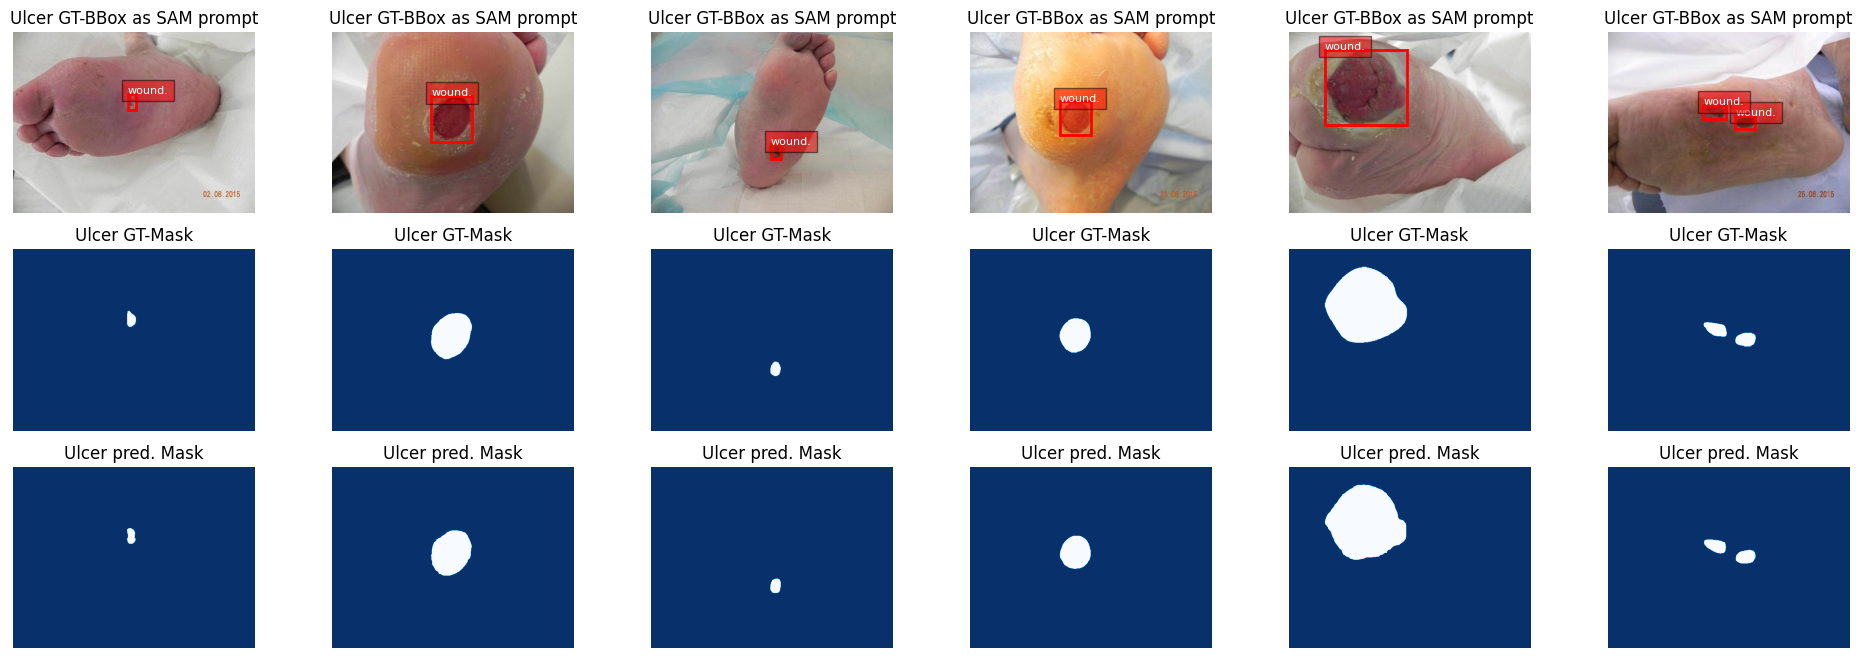

In [22]:
images, masks, targets = next(dataiter) # get a random batch of train_loader iterator

with torch.no_grad():
    sam_model.eval()

    # forward SAM to get segmentations
    sam_prompts = convert_bbox_format2sam_prompts(cxcywh2xyxy(targets), image_width=images.shape[3], image_height=images.shape[2])
    sam_inputs = sam_processor(images=images, input_boxes=sam_prompts, return_tensors="pt").to(device)
    
    with autocast(device_type='cuda', dtype=torch.float16):
        sam_outputs = sam_model(**sam_inputs, return_dict=True, multimask_output=False)
    
    pred_masks = sam_processor.post_process_masks(masks=sam_outputs.pred_masks,original_sizes=sam_inputs.original_sizes,reshaped_input_sizes=sam_inputs.reshaped_input_sizes,binarize=False) # Do not binarise here as gradients will be lost
    pred_masks = torch.stack([torch.max(mask, dim=0).values.squeeze() for mask in pred_masks], dim=0)  # combine multiply seg. instances into one semantic seg.
    pred_masks = (pred_masks.sigmoid() > 0.5).int() # binarize here
    
show_preds(images, masks, targets, pred_masks.cpu().numpy(), n=6)